# Conditional Neural Processes (CNP) for Coherent.
[Conditional Neural Processes](https://arxiv.org/pdf/1807.01613.pdf) (CNPs) were
introduced as a continuation of
[Generative Query Networks](https://deepmind.com/blog/neural-scene-representation-and-rendering/)
(GQN) to extend its training regime to tasks beyond scene rendering, e.g. to
regression and classification.

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import datetime
import numpy as np
import os
from resum.utilities import plotting_utils_cnp as plotting
from resum.utilities import utilities as utils
from resum.conditional_neural_process import DataGeneration
from resum.conditional_neural_process import DeterministicModel
from torch.utils.tensorboard import SummaryWriter
import shap
import yaml

In [8]:
with open("../coherent/settings.yaml", "r") as f:
    config_file = yaml.safe_load(f)

TRAINING_EPOCHS = int(config_file["cnp_settings"]["training_epochs"]) # Total number of training points: training_iterations * batch_size * max_content_points
PLOT_AFTER = int(config_file["cnp_settings"]["plot_after"])
torch.manual_seed(0)
BATCH_SIZE = config_file["cnp_settings"]["batch_size_train"]
FILES_PER_BATCH = config_file["cnp_settings"]["files_per_batch_train"]
target_range = config_file["simulation_settings"]["target_range"]
is_binary = target_range[0] >= 0 and target_range[1] <= 1

path_out = config_file["path_settings"]["path_out_cnp"]
version = config_file["path_settings"]["version"]

In [9]:
x_size, y_size = utils.get_feature_and_label_size(config_file)

Data Augmentation in Progress: Applying transformations...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.01s/it]


2025-06-30 11:15:59 Iteration: 0/0, train loss: 0.7886 (vs BCE 0.7044)
2025-06-30 11:15:59, Iteration: 0, test loss: 0.8289 (vs BCE 0.7121)


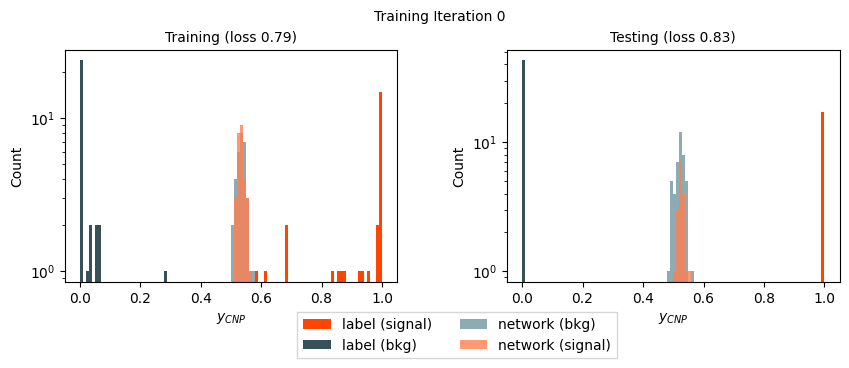

2025-06-30 11:16:03 Iteration: 0/200, train loss: 0.6788 (vs BCE 0.5153)
2025-06-30 11:16:03, Iteration: 200, test loss: 0.6791 (vs BCE 0.3878)


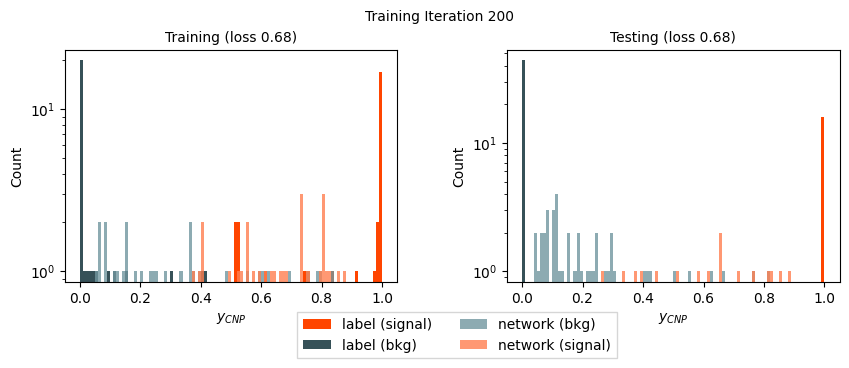

2025-06-30 11:16:08 Iteration: 0/400, train loss: 0.6859 (vs BCE 0.5320)
2025-06-30 11:16:08, Iteration: 400, test loss: 0.7504 (vs BCE 0.5489)


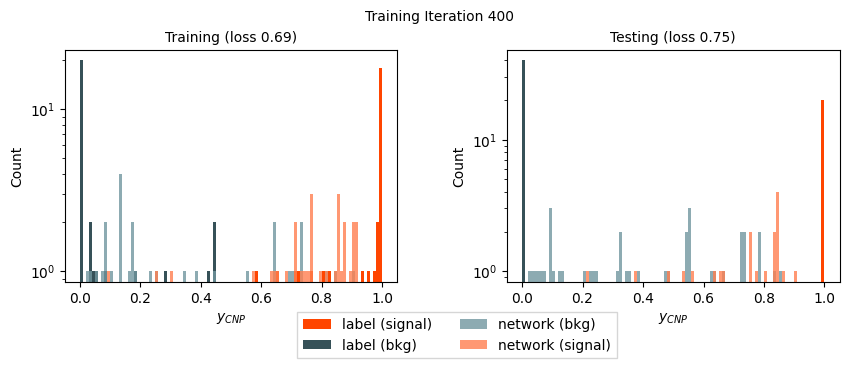

2025-06-30 11:16:13 Iteration: 0/600, train loss: 0.7246 (vs BCE 0.5630)
2025-06-30 11:16:13, Iteration: 600, test loss: 0.7272 (vs BCE 0.4859)


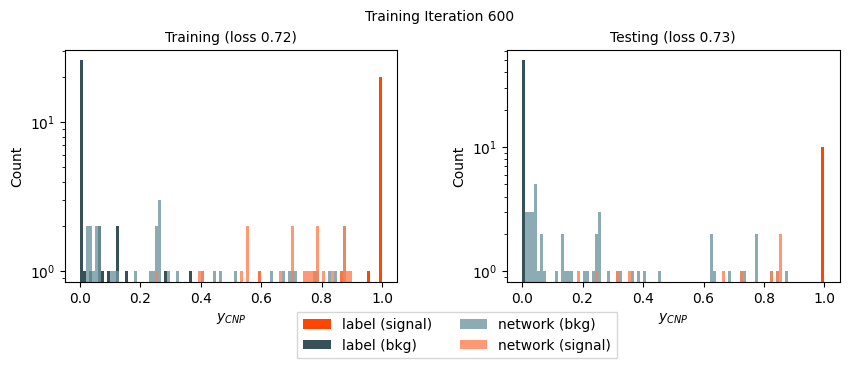

2025-06-30 11:16:17 Iteration: 0/800, train loss: 0.7028 (vs BCE 0.5414)
2025-06-30 11:16:17, Iteration: 800, test loss: 0.7264 (vs BCE 0.5046)


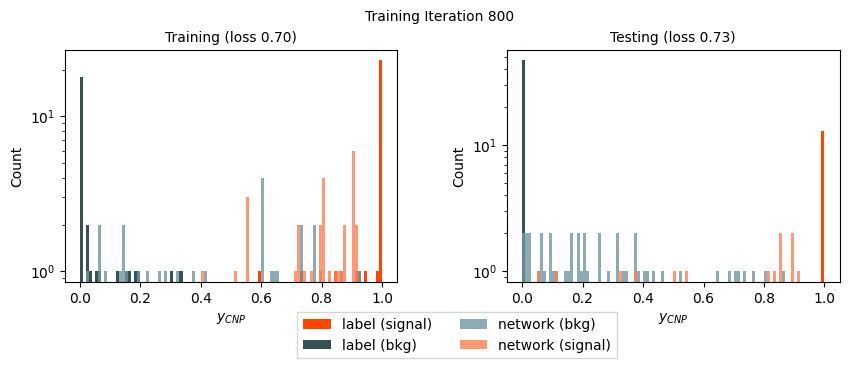

2025-06-30 11:16:22 Iteration: 0/1000, train loss: 0.6966 (vs BCE 0.5617)
2025-06-30 11:16:22, Iteration: 1000, test loss: 0.6930 (vs BCE 0.4509)


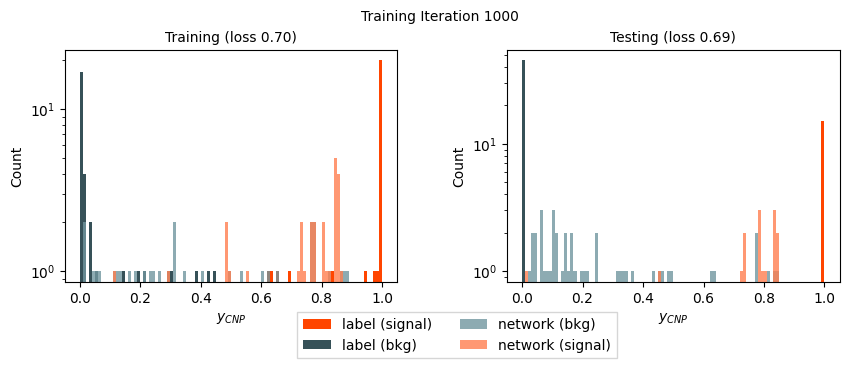

2025-06-30 11:16:27 Iteration: 0/1200, train loss: 0.7043 (vs BCE 0.5236)
2025-06-30 11:16:27, Iteration: 1200, test loss: 0.6901 (vs BCE 0.3993)


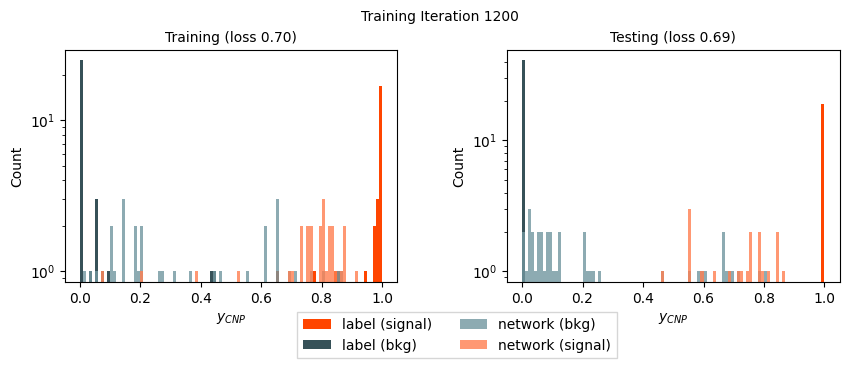

2025-06-30 11:16:31 Iteration: 0/1400, train loss: 0.6748 (vs BCE 0.4989)
2025-06-30 11:16:31, Iteration: 1400, test loss: 0.7131 (vs BCE 0.4638)


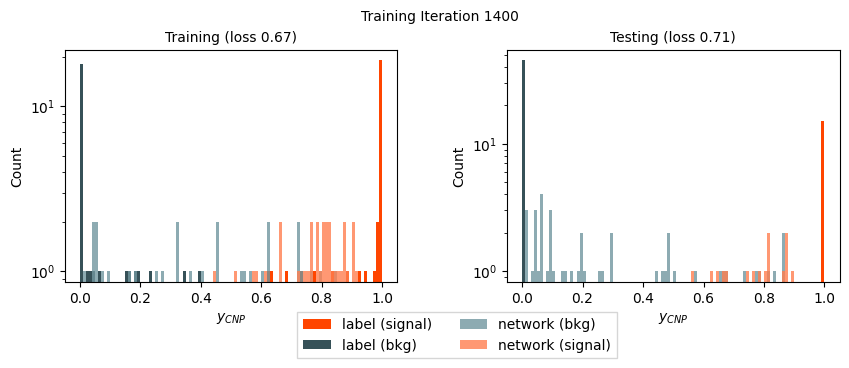

2025-06-30 11:16:36 Iteration: 0/1600, train loss: 0.7160 (vs BCE 0.5884)
2025-06-30 11:16:36, Iteration: 1600, test loss: 0.7121 (vs BCE 0.4635)


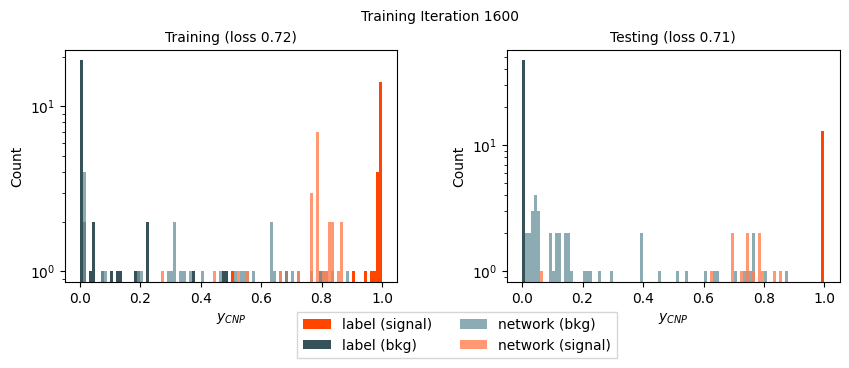

2025-06-30 11:16:41 Iteration: 0/1800, train loss: 0.6033 (vs BCE 0.3657)
2025-06-30 11:16:41, Iteration: 1800, test loss: 0.6778 (vs BCE 0.3680)


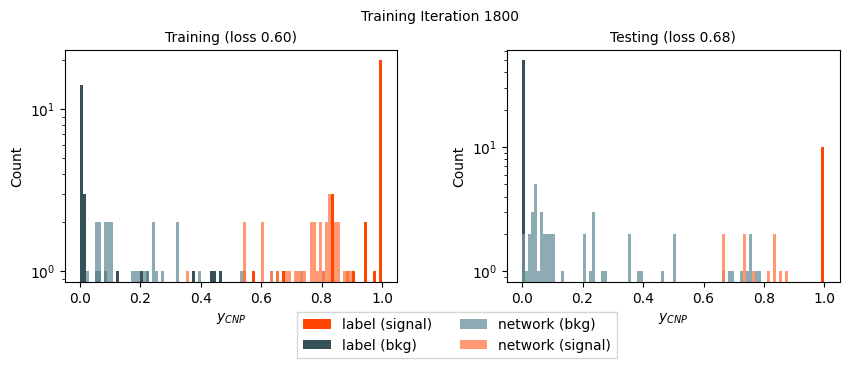

2025-06-30 11:16:45 Iteration: 0/2000, train loss: 0.7003 (vs BCE 0.5692)
2025-06-30 11:16:45, Iteration: 2000, test loss: 0.6956 (vs BCE 0.4245)


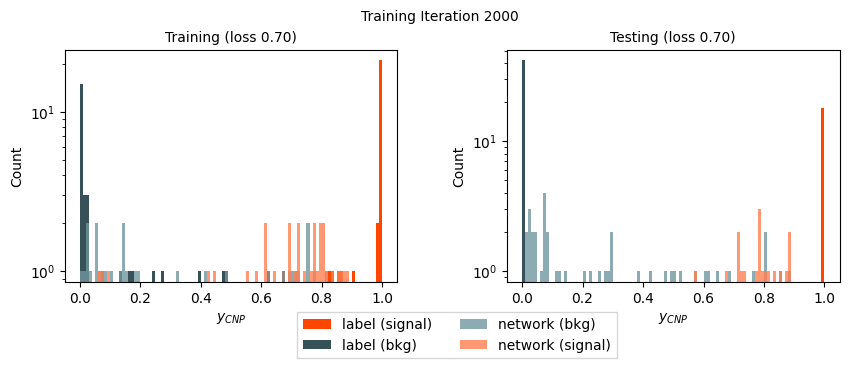

2025-06-30 11:16:50 Iteration: 0/2200, train loss: 0.6731 (vs BCE 0.4565)
2025-06-30 11:16:50, Iteration: 2200, test loss: 0.6757 (vs BCE 0.3668)


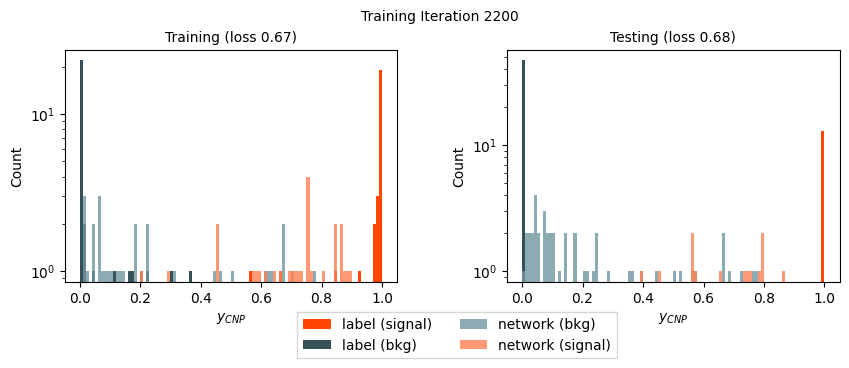

2025-06-30 11:16:55 Iteration: 0/2400, train loss: 0.6827 (vs BCE 0.5178)
2025-06-30 11:16:55, Iteration: 2400, test loss: 0.6686 (vs BCE 0.3466)


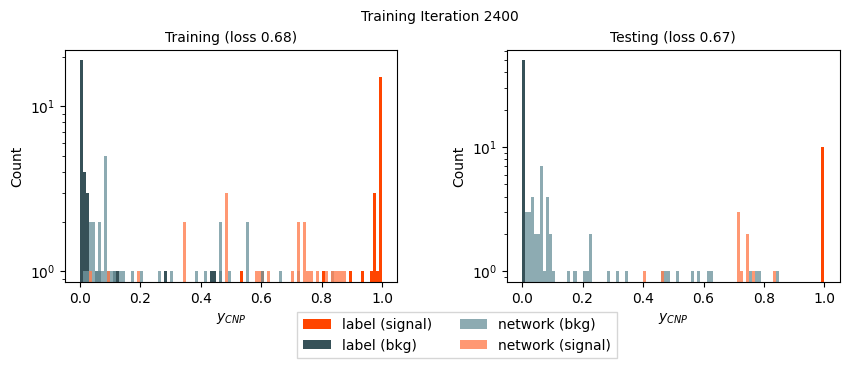

2025-06-30 11:16:59 Iteration: 0/2600, train loss: 0.6754 (vs BCE 0.5224)
2025-06-30 11:16:59, Iteration: 2600, test loss: 0.6569 (vs BCE 0.3134)


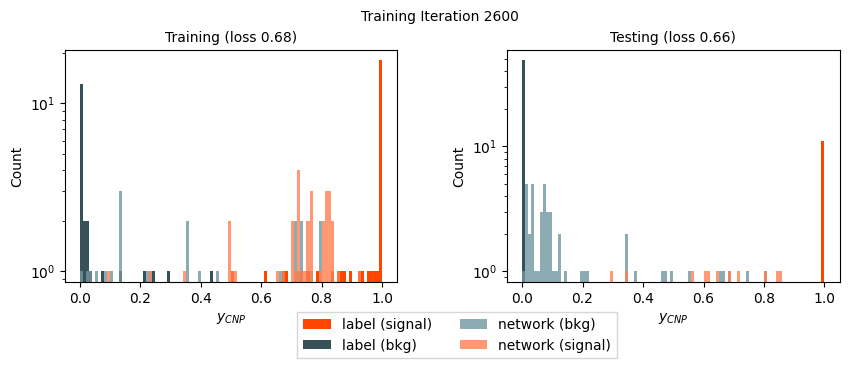

2025-06-30 11:17:04 Iteration: 0/2800, train loss: 0.6591 (vs BCE 0.4895)
2025-06-30 11:17:04, Iteration: 2800, test loss: 0.6839 (vs BCE 0.3936)


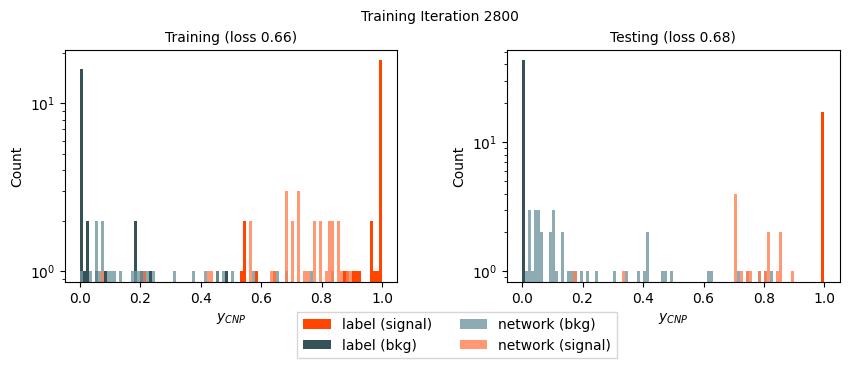

2025-06-30 11:17:09 Iteration: 0/3000, train loss: 0.6819 (vs BCE 0.5147)
2025-06-30 11:17:09, Iteration: 3000, test loss: 0.7187 (vs BCE 0.4785)


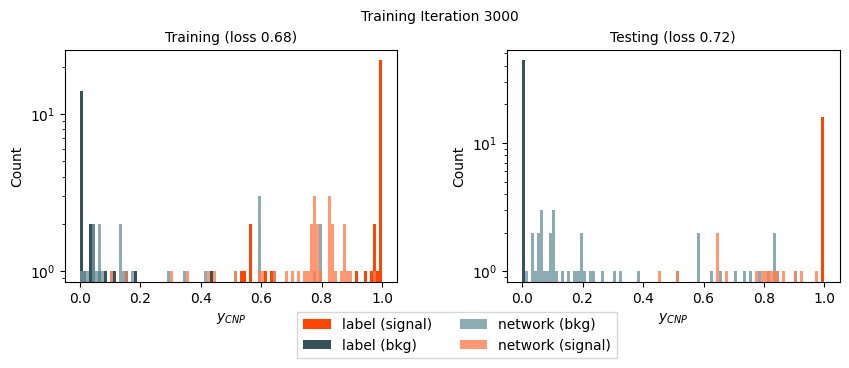

2025-06-30 11:17:13 Iteration: 0/3200, train loss: 0.6742 (vs BCE 0.5129)
2025-06-30 11:17:13, Iteration: 3200, test loss: 0.6669 (vs BCE 0.3585)


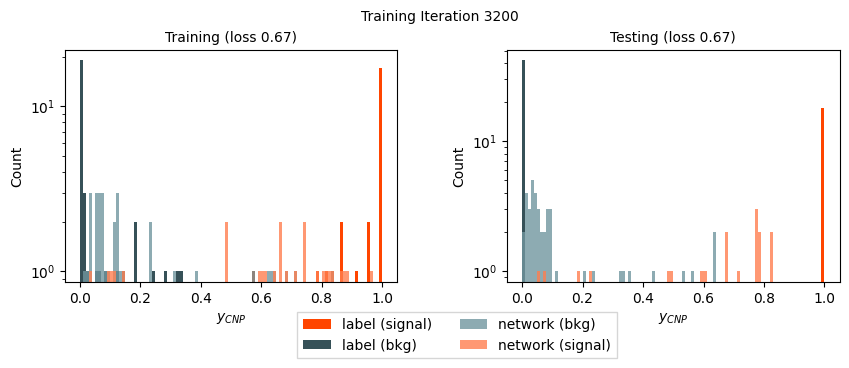

2025-06-30 11:17:18 Iteration: 0/3400, train loss: 0.6784 (vs BCE 0.4790)
2025-06-30 11:17:18, Iteration: 3400, test loss: 0.7536 (vs BCE 0.5605)


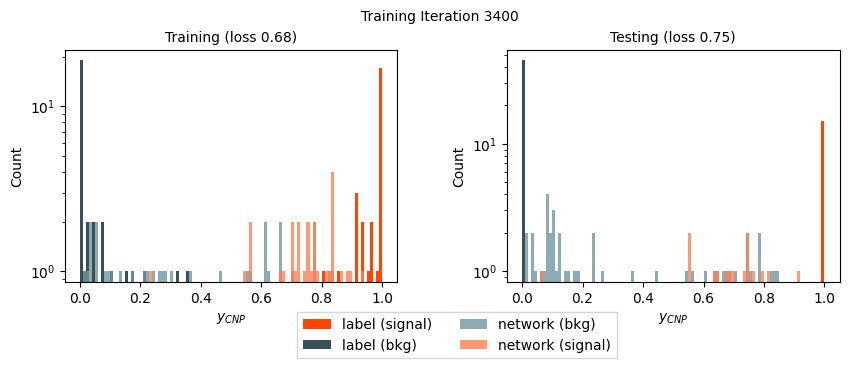

2025-06-30 11:17:23 Iteration: 0/3600, train loss: 0.7276 (vs BCE 0.6194)
2025-06-30 11:17:23, Iteration: 3600, test loss: 0.7130 (vs BCE 0.4743)


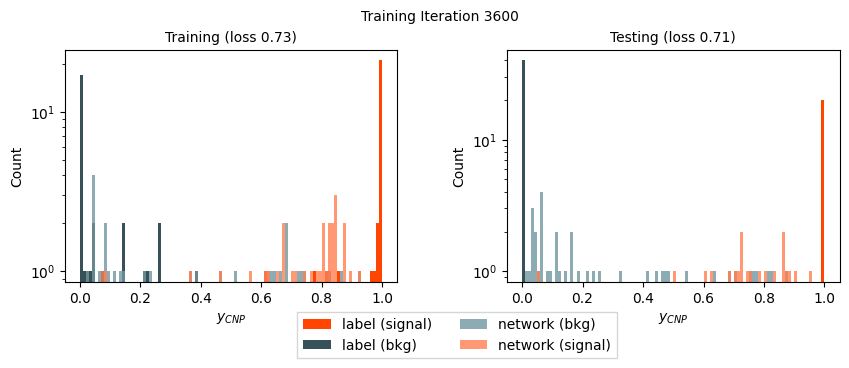

2025-06-30 11:17:27 Iteration: 0/3800, train loss: 0.6807 (vs BCE 0.5214)
2025-06-30 11:17:27, Iteration: 3800, test loss: 0.7672 (vs BCE 0.5880)


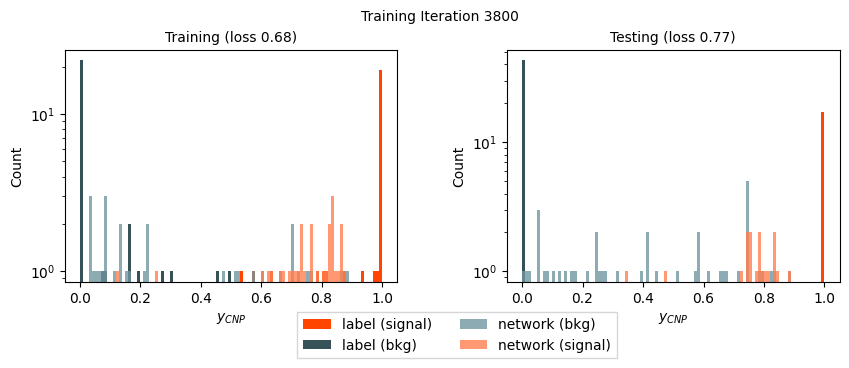

2025-06-30 11:17:32 Iteration: 0/4000, train loss: 0.6641 (vs BCE 0.5124)
2025-06-30 11:17:32, Iteration: 4000, test loss: 0.7083 (vs BCE 0.4522)


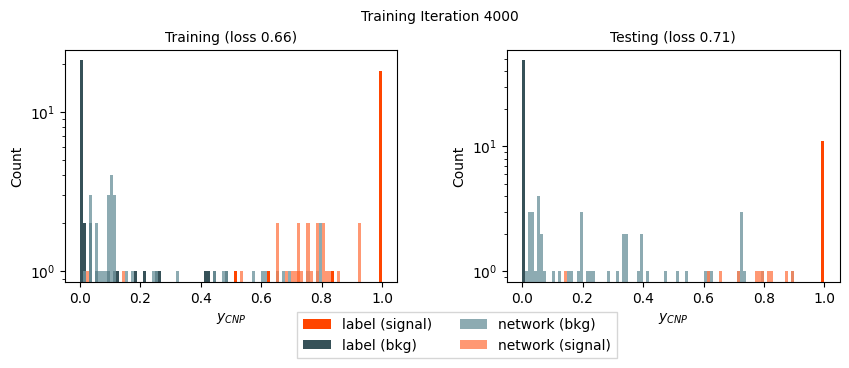

2025-06-30 11:17:37 Iteration: 0/4200, train loss: 0.6599 (vs BCE 0.4875)
2025-06-30 11:17:37, Iteration: 4200, test loss: 0.7340 (vs BCE 0.5098)


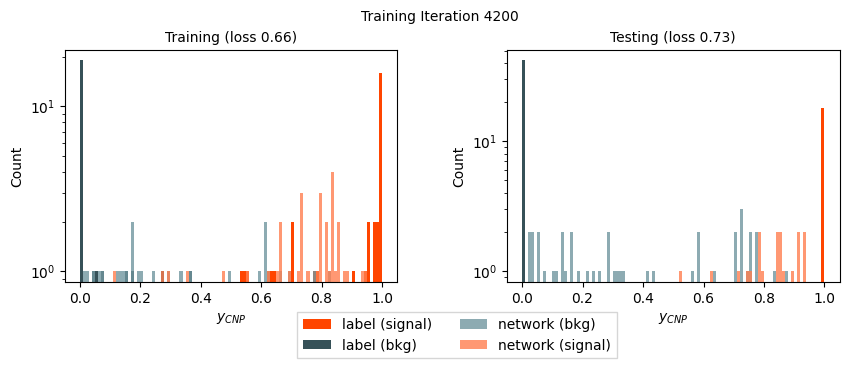

2025-06-30 11:17:41 Iteration: 0/4400, train loss: 0.6227 (vs BCE 0.3618)
2025-06-30 11:17:41, Iteration: 4400, test loss: 0.6899 (vs BCE 0.4043)


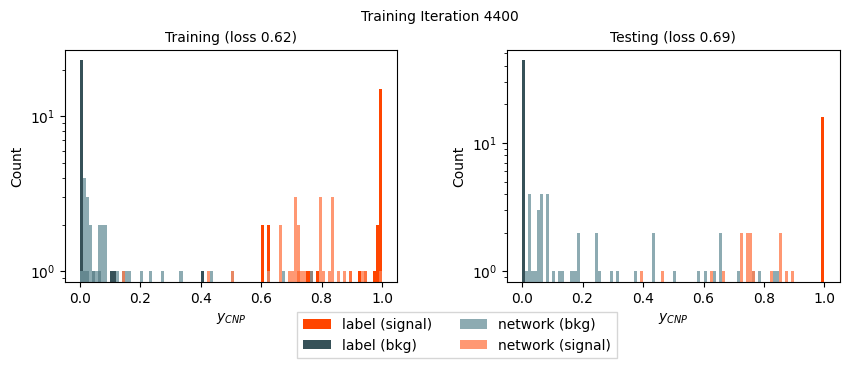

2025-06-30 11:17:46 Iteration: 0/4600, train loss: 0.7234 (vs BCE 0.6037)
2025-06-30 11:17:46, Iteration: 4600, test loss: 0.6732 (vs BCE 0.3587)


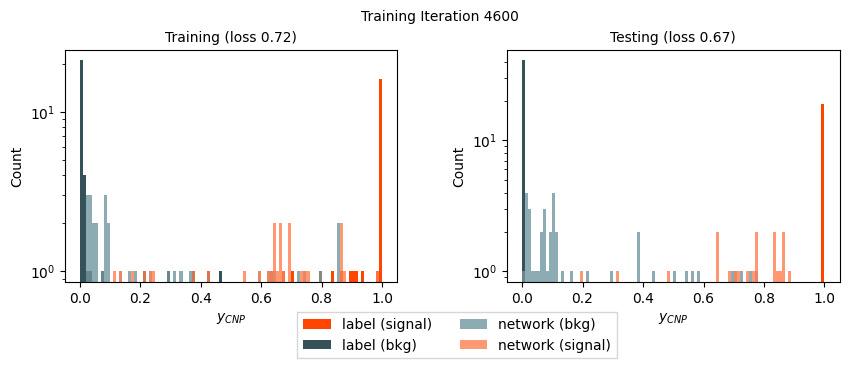

2025-06-30 11:17:51 Iteration: 0/4800, train loss: 0.6639 (vs BCE 0.4748)
2025-06-30 11:17:51, Iteration: 4800, test loss: 0.7295 (vs BCE 0.5034)


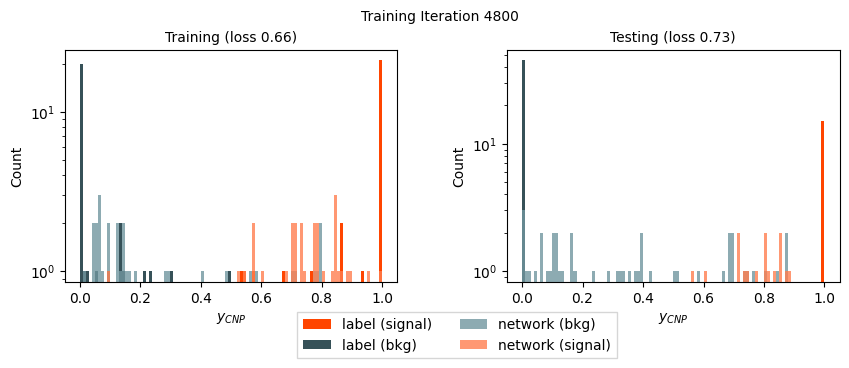

2025-06-30 11:17:55 Iteration: 0/5000, train loss: 0.6407 (vs BCE 0.3791)
2025-06-30 11:17:55, Iteration: 5000, test loss: 0.7052 (vs BCE 0.4412)


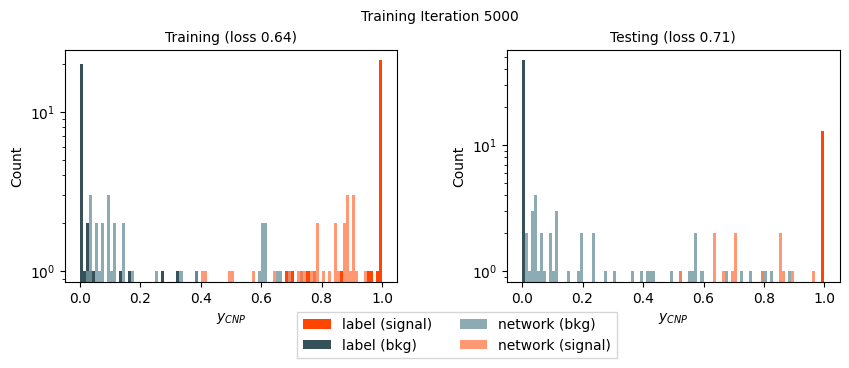

2025-06-30 11:18:00 Iteration: 0/5200, train loss: 0.6771 (vs BCE 0.4757)
2025-06-30 11:18:00, Iteration: 5200, test loss: 0.6713 (vs BCE 0.3481)


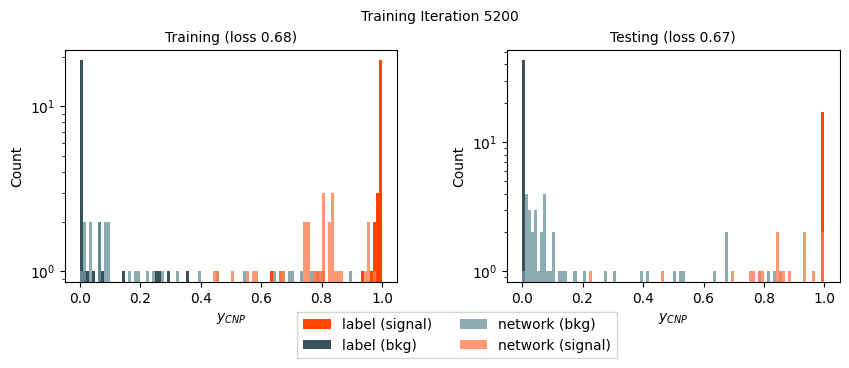

2025-06-30 11:18:05 Iteration: 0/5400, train loss: 0.6685 (vs BCE 0.5080)
2025-06-30 11:18:05, Iteration: 5400, test loss: 0.6511 (vs BCE 0.3140)


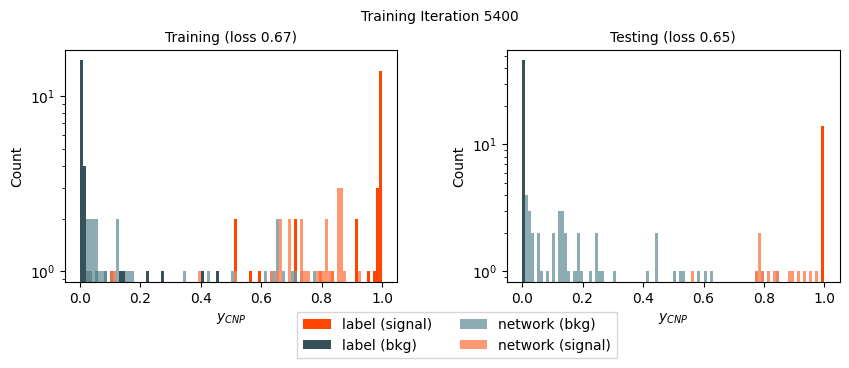

2025-06-30 11:18:10 Iteration: 0/5600, train loss: 0.6755 (vs BCE 0.4826)
2025-06-30 11:18:10, Iteration: 5600, test loss: 0.6733 (vs BCE 0.3602)


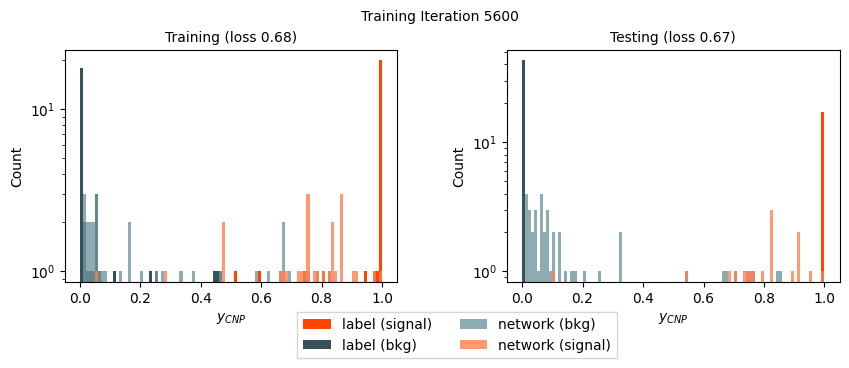

2025-06-30 11:18:14 Iteration: 0/5800, train loss: 0.6291 (vs BCE 0.4107)
2025-06-30 11:18:14, Iteration: 5800, test loss: 0.7113 (vs BCE 0.4534)


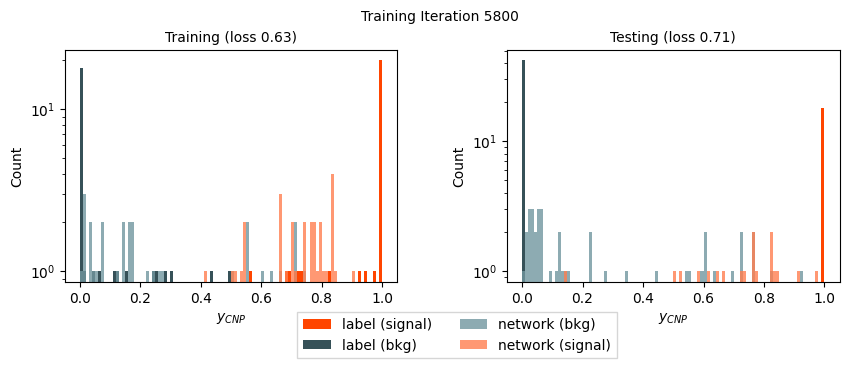

2025-06-30 11:18:19 Iteration: 0/6000, train loss: 0.6337 (vs BCE 0.3696)
2025-06-30 11:18:19, Iteration: 6000, test loss: 0.7503 (vs BCE 0.5405)


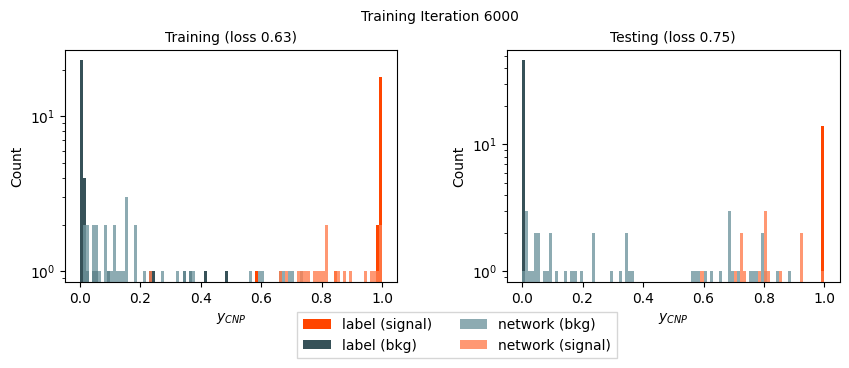

2025-06-30 11:18:23 Iteration: 0/6200, train loss: 0.6431 (vs BCE 0.4095)
2025-06-30 11:18:23, Iteration: 6200, test loss: 0.6994 (vs BCE 0.4110)


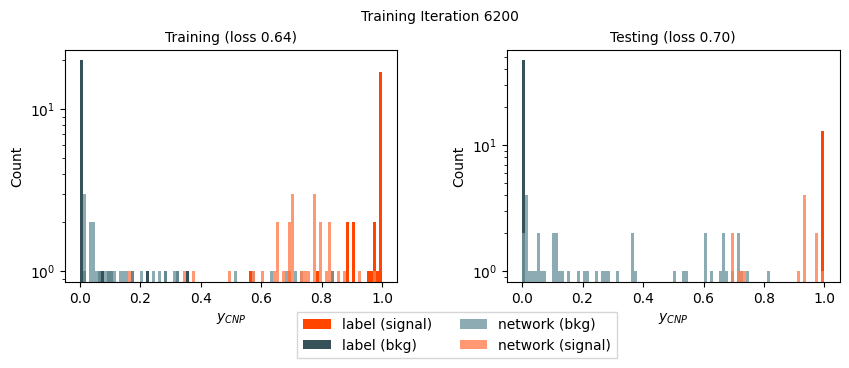

2025-06-30 11:18:28 Iteration: 0/6400, train loss: 0.6523 (vs BCE 0.4392)
2025-06-30 11:18:28, Iteration: 6400, test loss: 0.6744 (vs BCE 0.3560)


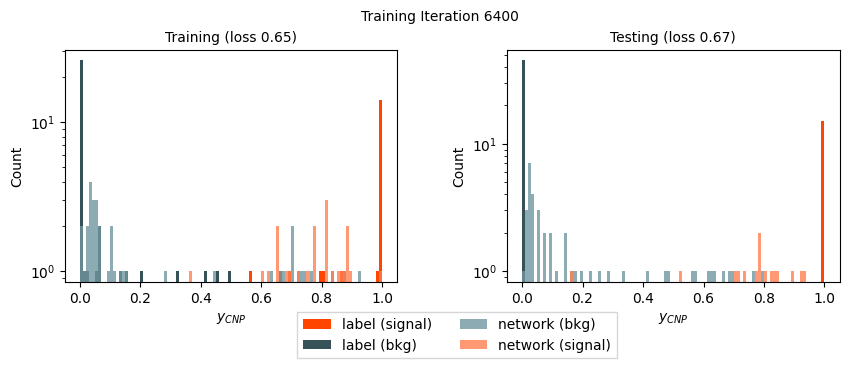

2025-06-30 11:18:32 Iteration: 0/6600, train loss: 0.6510 (vs BCE 0.4527)
2025-06-30 11:18:32, Iteration: 6600, test loss: 0.7153 (vs BCE 0.4635)


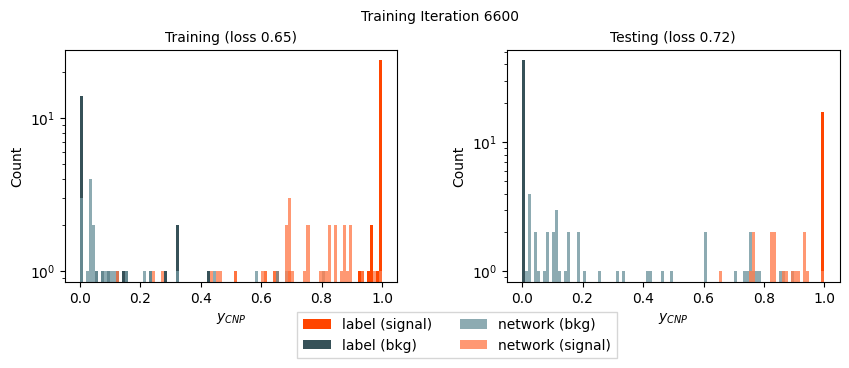

2025-06-30 11:18:37 Iteration: 0/6800, train loss: 0.6856 (vs BCE 0.4886)
2025-06-30 11:18:37, Iteration: 6800, test loss: 0.6983 (vs BCE 0.4184)


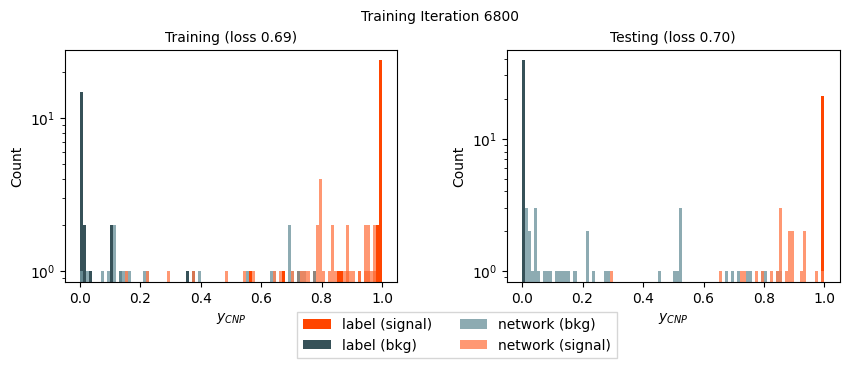

2025-06-30 11:18:42 Iteration: 0/7000, train loss: 0.6796 (vs BCE 0.4953)
2025-06-30 11:18:42, Iteration: 7000, test loss: 0.6926 (vs BCE 0.3978)


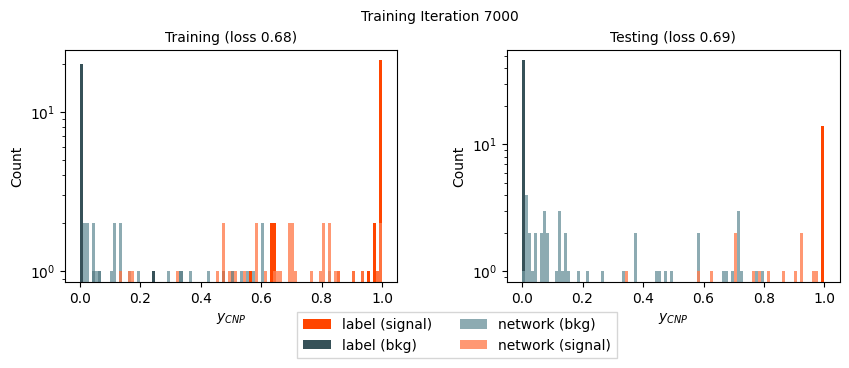

2025-06-30 11:18:46 Iteration: 0/7200, train loss: 0.6687 (vs BCE 0.5506)
2025-06-30 11:18:46, Iteration: 7200, test loss: 0.7562 (vs BCE 0.5550)


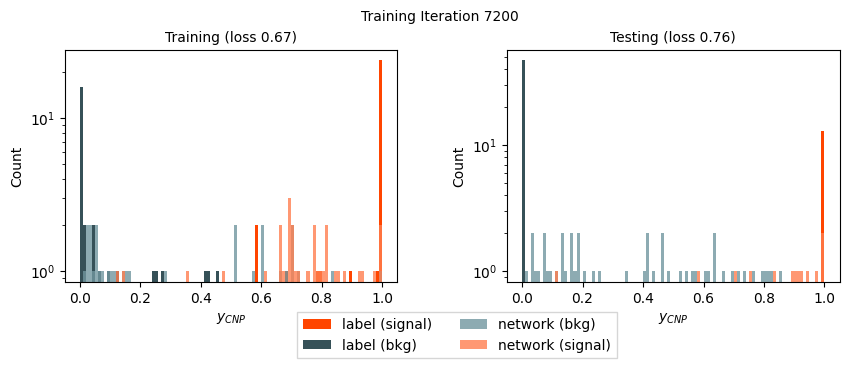

2025-06-30 11:18:51 Iteration: 0/7400, train loss: 0.6853 (vs BCE 0.4851)
2025-06-30 11:18:51, Iteration: 7400, test loss: 0.7837 (vs BCE 0.6234)


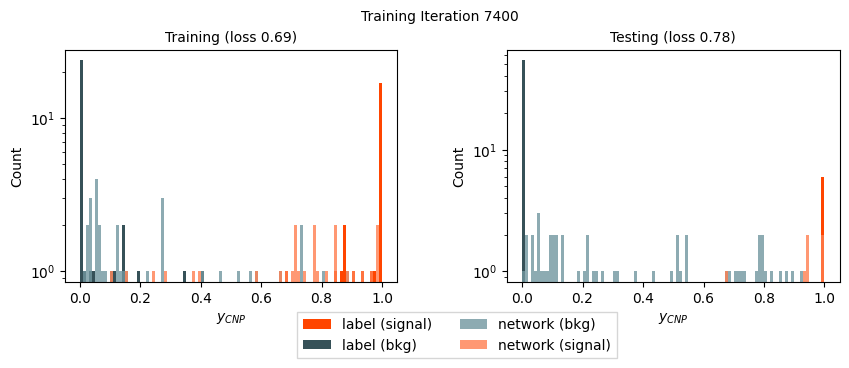

2025-06-30 11:18:56 Iteration: 0/7600, train loss: 0.6502 (vs BCE 0.4027)
2025-06-30 11:18:56, Iteration: 7600, test loss: 0.7307 (vs BCE 0.4942)


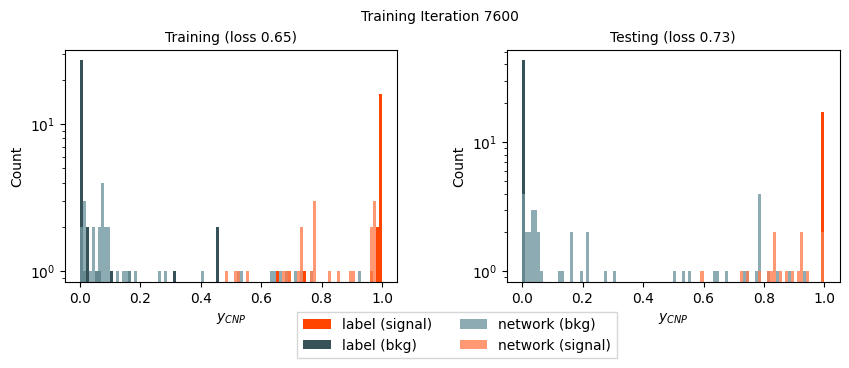

2025-06-30 11:19:00 Iteration: 0/7800, train loss: 0.6308 (vs BCE 0.3968)
2025-06-30 11:19:00, Iteration: 7800, test loss: 0.6542 (vs BCE 0.3084)


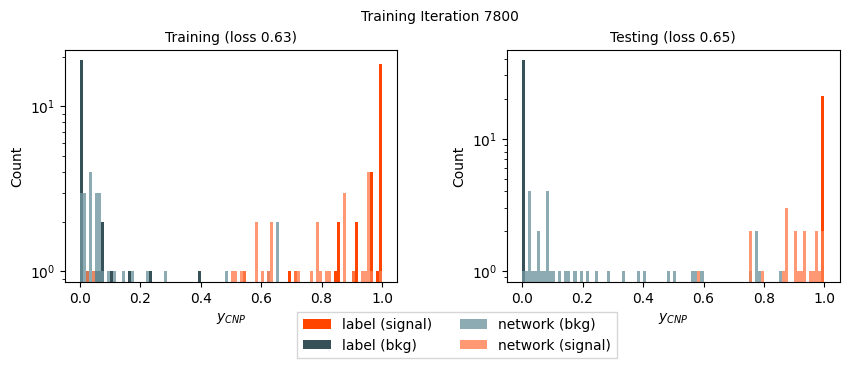

2025-06-30 11:19:05 Iteration: 0/8000, train loss: 0.6658 (vs BCE 0.4715)
2025-06-30 11:19:05, Iteration: 8000, test loss: 0.8653 (vs BCE 0.8666)


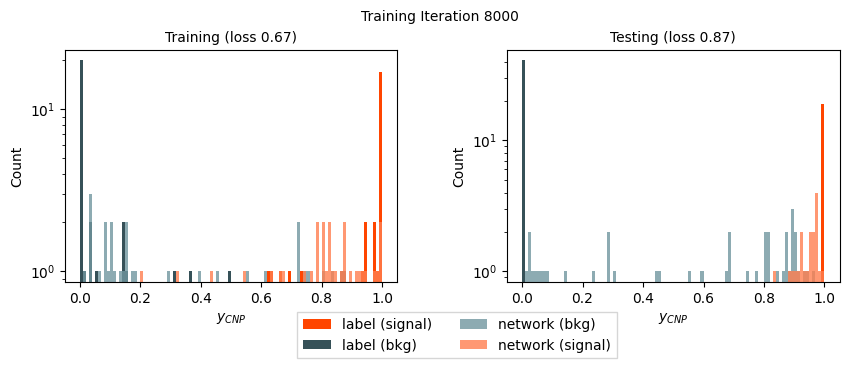

2025-06-30 11:19:10 Iteration: 0/8200, train loss: 0.6776 (vs BCE 0.4632)
2025-06-30 11:19:10, Iteration: 8200, test loss: 0.8108 (vs BCE 0.6743)


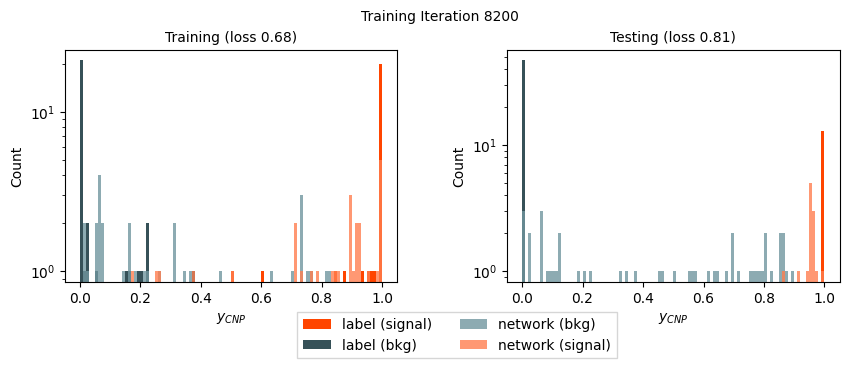

2025-06-30 11:19:14 Iteration: 0/8400, train loss: 0.6407 (vs BCE 0.3938)
2025-06-30 11:19:14, Iteration: 8400, test loss: 0.7939 (vs BCE 0.6408)


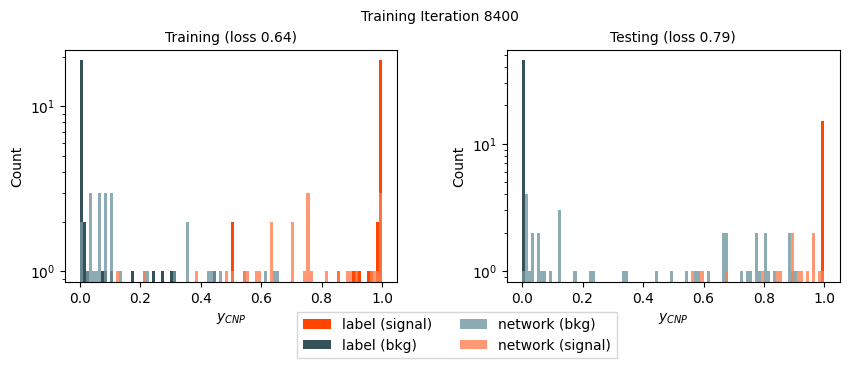

2025-06-30 11:19:19 Iteration: 0/8600, train loss: 0.6610 (vs BCE 0.4494)
2025-06-30 11:19:19, Iteration: 8600, test loss: 0.8576 (vs BCE 0.8401)


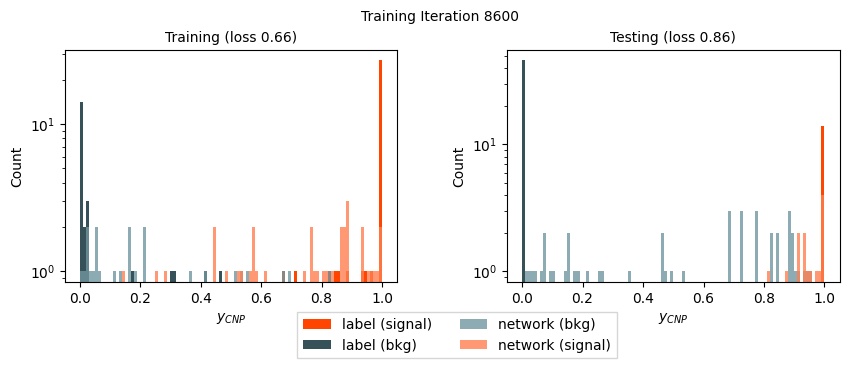

2025-06-30 11:19:24 Iteration: 0/8800, train loss: 0.6283 (vs BCE 0.4275)
2025-06-30 11:19:24, Iteration: 8800, test loss: 0.8535 (vs BCE 0.8128)


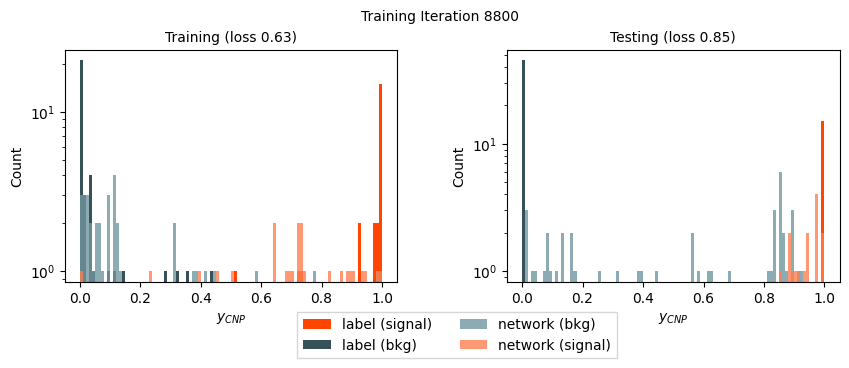

2025-06-30 11:19:29 Iteration: 0/9000, train loss: 0.6570 (vs BCE 0.5734)
2025-06-30 11:19:29, Iteration: 9000, test loss: 0.7817 (vs BCE 0.6157)


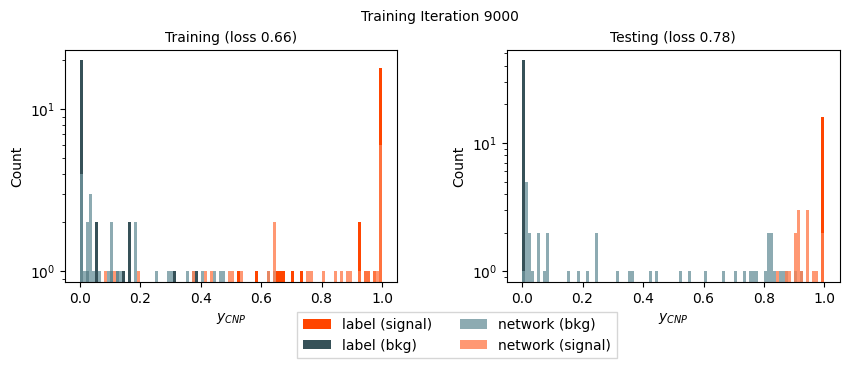

2025-06-30 11:19:33 Iteration: 0/9200, train loss: 0.6282 (vs BCE 0.3692)
2025-06-30 11:19:33, Iteration: 9200, test loss: 0.8644 (vs BCE 0.8497)


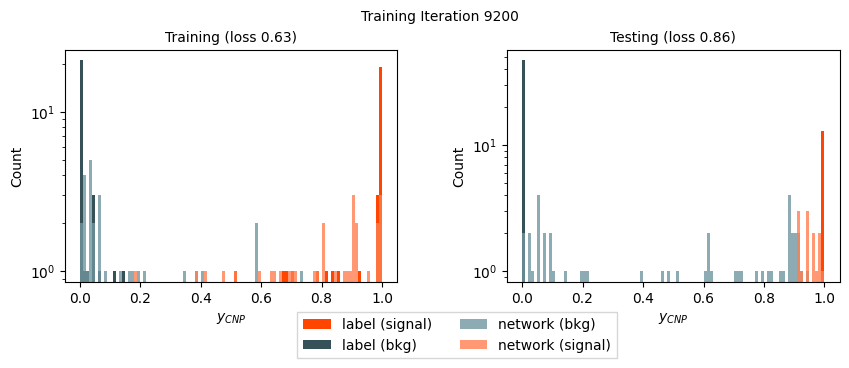

2025-06-30 11:19:38 Iteration: 0/9400, train loss: 0.6184 (vs BCE 0.3614)
2025-06-30 11:19:38, Iteration: 9400, test loss: 0.9229 (vs BCE 0.9682)


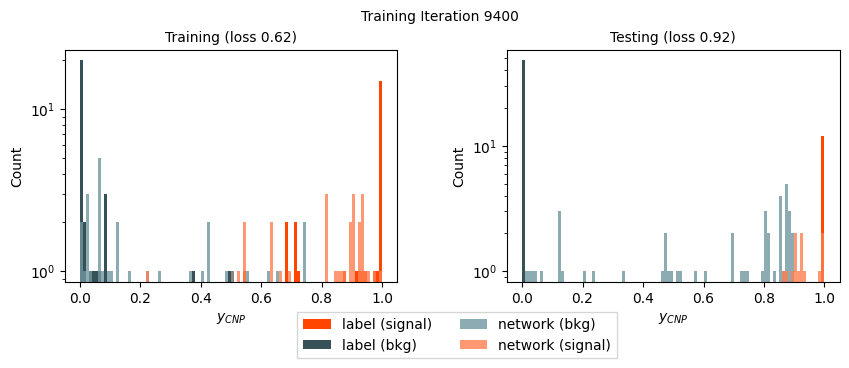

In [10]:

d_x, d_in, representation_size, d_out = x_size , x_size+y_size, 32, y_size*2
encoder_sizes = [d_in, 32, 64, 128, 128, 128, 64, 48, representation_size]
decoder_sizes = [representation_size + d_x, 32, 64, 128, 128, 128, 64, 48, d_out]

model = DeterministicModel(encoder_sizes, decoder_sizes)
writer = SummaryWriter(log_dir=f'{path_out}/cnp_{version}_tensorboard_logs')

optimizer = optim.Adam(model.parameters(), lr=1e-4)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
# 

bce = nn.BCELoss()
iter_testing = 0

# create a PdfPages object
test_idx=0
it_batch = 0
for it_epoch in range(TRAINING_EPOCHS):
    
    USE_DATA_AUGMENTATION = config_file["cnp_settings"]["use_data_augmentation"]
    # load data:
    dataset_train = DataGeneration(mode = "training", 
                                   config_file=config_file, 
                                   path_to_files=config_file["path_settings"]["path_to_files_train"], 
                                   use_data_augmentation=USE_DATA_AUGMENTATION, 
                                   batch_size=BATCH_SIZE,
                                   files_per_batch=FILES_PER_BATCH)
    dataset_train.set_loader()
    dataloader_train = dataset_train.dataloader

    dataset_test = DataGeneration(mode = "training", 
                                  config_file=config_file, 
                                  path_to_files=config_file["path_settings"]["path_to_files_train"], 
                                  use_data_augmentation=False, 
                                  batch_size=BATCH_SIZE,
                                  files_per_batch=FILES_PER_BATCH)
    dataset_test.set_loader()
    dataloader_test = dataset_test.dataloader
    data_iter = iter(dataloader_test)

    #it_batch = 0
    
    for b, batch in enumerate(dataloader_train):
        batch_formated=dataset_train.format_batch_for_cnp(batch,config_file["cnp_settings"]["context_is_subset"] )
        # Get the predicted mean and variance at the target points for the testing set
        log_prob, mu, _ = model(batch_formated.query, batch_formated.target_y, is_binary)
        
        # Define the loss
        loss = -log_prob.mean()
        loss.backward()

        # Perform gradient descent to update parameters
        optimizer.step()
    
        # reset gradient to 0 on all parameters
        optimizer.zero_grad()
        
        if is_binary:
            loss_bce = bce(mu, batch_formated.target_y)
        else:
            loss_bce=-1
        
        # Inside your batch loop, right after computing losses:
        writer.add_scalar('Loss/train_logprob', loss.item(), it_batch)
        if is_binary:
            writer.add_scalar('Loss/train_BCE', loss_bce.item(), it_batch)

        
        mu=mu[0].detach().numpy()
        
        if it_batch % PLOT_AFTER == 0:
            batch_testing = next(data_iter)
            batch_formated_test=dataset_test.format_batch_for_cnp(batch_testing,config_file["cnp_settings"]["context_is_subset"] )
          
            print('{} Iteration: {}/{}, train loss: {:.4f} (vs BCE {:.4f})'.format(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),it_epoch, it_batch,loss, loss_bce))
            
            writer.add_scalar('Loss/train_logprob', loss.item(), iter_testing)
            if is_binary:
                writer.add_scalar('Loss/train_BCE', loss_bce.item(), iter_testing)

            log_prob_testing, mu_testing, _ = model(batch_formated_test.query, batch_formated_test.target_y, is_binary)
            loss_testing = -log_prob_testing.mean()
            

            if is_binary:
                loss_bce_testing = bce(mu_testing,  batch_formated_test.target_y)
            else:
                loss_bce_testing = -1.

            writer.add_scalar('Loss/test_logprob', loss_testing.item(), test_idx)
            if is_binary:
                writer.add_scalar('Loss/test_BCE', loss_bce_testing.item(), test_idx)

            mu_testing = mu_testing[0].detach().numpy()
            print("{}, Iteration: {}, test loss: {:.4f} (vs BCE {:.4f})".format(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"), it_batch, loss_testing, loss_bce_testing))
            if y_size ==1:
                fig = plotting.plot(mu, batch_formated.target_y[0].detach().numpy(), f'{loss:.2f}', mu_testing, batch_formated_test.target_y[0].detach().numpy(), f'{loss_testing:.2f}', target_range, it_batch)
                writer.add_figure('Prediction/train_vs_test', fig, global_step=test_idx)
            else:
                for k in range(y_size):
                    fig = plotting.plot(mu[:,k], batch_formated.target_y[0].detach().numpy()[:,k], f'{loss:.2f}', mu_testing[:,k], batch_formated_test.target_y[0].detach().numpy()[:,k], f'{loss_testing:.2f}', target_range, it_batch)
                    writer.add_figure(f'Prediction/train_vs_test_k{k}', fig, global_step=test_idx)
            test_idx+=1
    
        it_batch+=1

writer.close()
torch.save(model.state_dict(), f'{path_out}/cnp_{version}_model.pth')
